# EDA Scenario

Imagine the following scenario:

A global nonprofit organization, focused on policy-based solutions to climate change and poverty, has hired me (a data science consultant) to use the WDI data set to explore which indicators they could focus on to reduce CO2 emissions. They plan to use my analysis to direct further research and support their government lobbying efforts.

To get to know my client better, I looked for information about them using a popular search engine. I suspect, based on a review of the nonprofits website, that they already have some preferred policy solutions and might not be willing to consider other solutions. For example, the client already has policy initiatives that support increases in wind and solar energy production but has stated opposition to increases in nuclear energy production. In addition, some of their broad goals may conflict with reducing CO2. For example, wind turbines can negatively impact bird and bat populations.

As a principled data scientist, I prefer not work on projects where the results are preordained (ethical commitment). My results might not be used or might be misrepresented to fit the clients preconceived notions about the ‘best’ policies to reduce CO2 emissions.  

Assuming that I must take on the project, there are several things I could do to build a productive relationship with the client. I think the best option is to answer the question as posed by the client and then answer the question I wish they would have asked. 


In [1]:
import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data
import json

In [2]:
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [4]:
# Read WDI data into a pandas dataframe
wdi_df = pd.read_csv('WDIData.csv')

# There are region names included in the country column and I only want to look at countries
# Using the WDICountry.csv to get a list of countries only
wdi_country_df = pd.read_csv('WDICountry.csv')
# getting list of only countries and not regions
country_only = wdi_country_df.dropna(subset=['Region'])
country_only = country_only['Table Name']
#print(country_only)
# filtering out regions
wdi_df = wdi_df.loc[wdi_df['Country Name'].isin(country_only)]

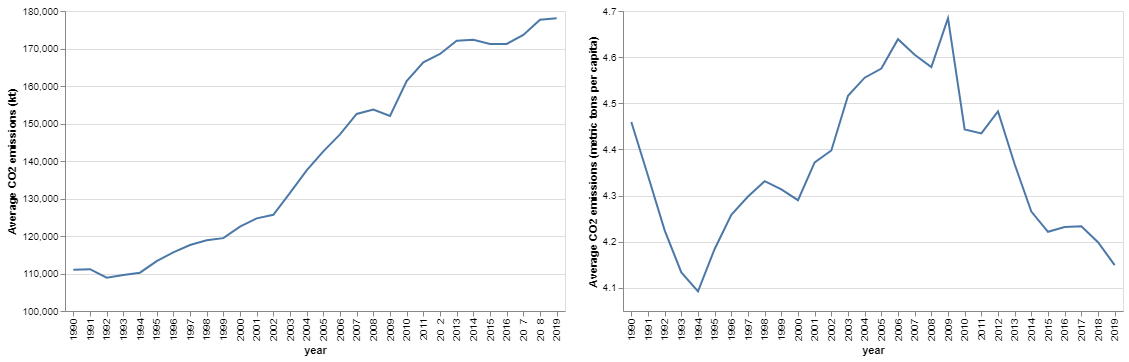

In [20]:
#Exploring some broad patterns in CO2 emissions
#getting average CO2 emissions across all countries
co2_all = wdi_df.loc[(wdi_df['Indicator Name'] == 'CO2 emissions (kt)')].mean(numeric_only=True)
#print(co2_all)

#getting average CO2 emissions per capita across all countries
co2_per_cap = wdi_df.loc[(wdi_df['Indicator Name'] == 'CO2 emissions (metric tons per capita)')].mean(numeric_only=True)

#making a new df for some charts
data = {'Average CO2 emissions (kt)': co2_all, 'Average CO2 emissions (metric tons per capita)': co2_per_cap, 'year': co2_all.index.values}
source = pd.DataFrame(data=data)
source = source.dropna(axis=0)
#print(source)



chart1= alt.Chart(source).mark_line().encode(
    x= alt.X('year'),
    y= alt.Y('Average CO2 emissions (kt)', scale=alt.Scale(zero=False)),
).properties(width=500, height=300, title='')

chart2= alt.Chart(source).mark_line().encode(
    x= alt.X('year'),
    y= alt.Y('Average CO2 emissions (metric tons per capita)', scale=alt.Scale(zero=False)),
).properties(width=500, height=300, title='')
charts = chart1 | chart2
charts


The charts above show that total CO2 emissions are increasing while CO2 emissions per capita are decreasing.  

In [7]:
#make a functon that returns a new df from a list of indicatior values and a year as string
def get_ind_df(df, indi_list, year):
    new_df = df[['Country Name','Indicator Name',year]]
    d= {'Country Name': new_df['Country Name'].unique()}
    output_df= pd.DataFrame(data=d)
    for indi in indi_list:
        temp_df = new_df[new_df['Indicator Name']== indi]
        temp_df = temp_df.rename(columns={ year : indi +' '+ year})
        temp_df = temp_df[['Country Name', indi +' '+ year]]
        output_df = output_df.merge(temp_df, how='outer', on='Country Name' )
    return output_df

In addition to CO2 related indicators, I wanted to explore other environment related indicators that might be related to CO2 emissions. 

In [8]:
indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)','Urban population (% of total population)',
             'Energy use (kg of oil equivalent per capita)','Renewable electricity output (% of total electricity output)',
             'Population, total','GDP (current US$)','Multidimensional poverty headcount ratio (% of total population)',
              'Access to electricity (% of population)','Electricity production from nuclear sources (% of total)',
              'Forest area (% of land area)']


Now I'll use the function and list of indicators to make a new dataframe. I can then use the new dataframe to explore relationships between indicators. A type of small multiple visualization called a scatter plot matrix is often useful to explore the relationships between many variables.

In [9]:
splom_data = get_ind_df(wdi_df, indi_list, '2015')
#print(splom_data.columns)
#splom_data

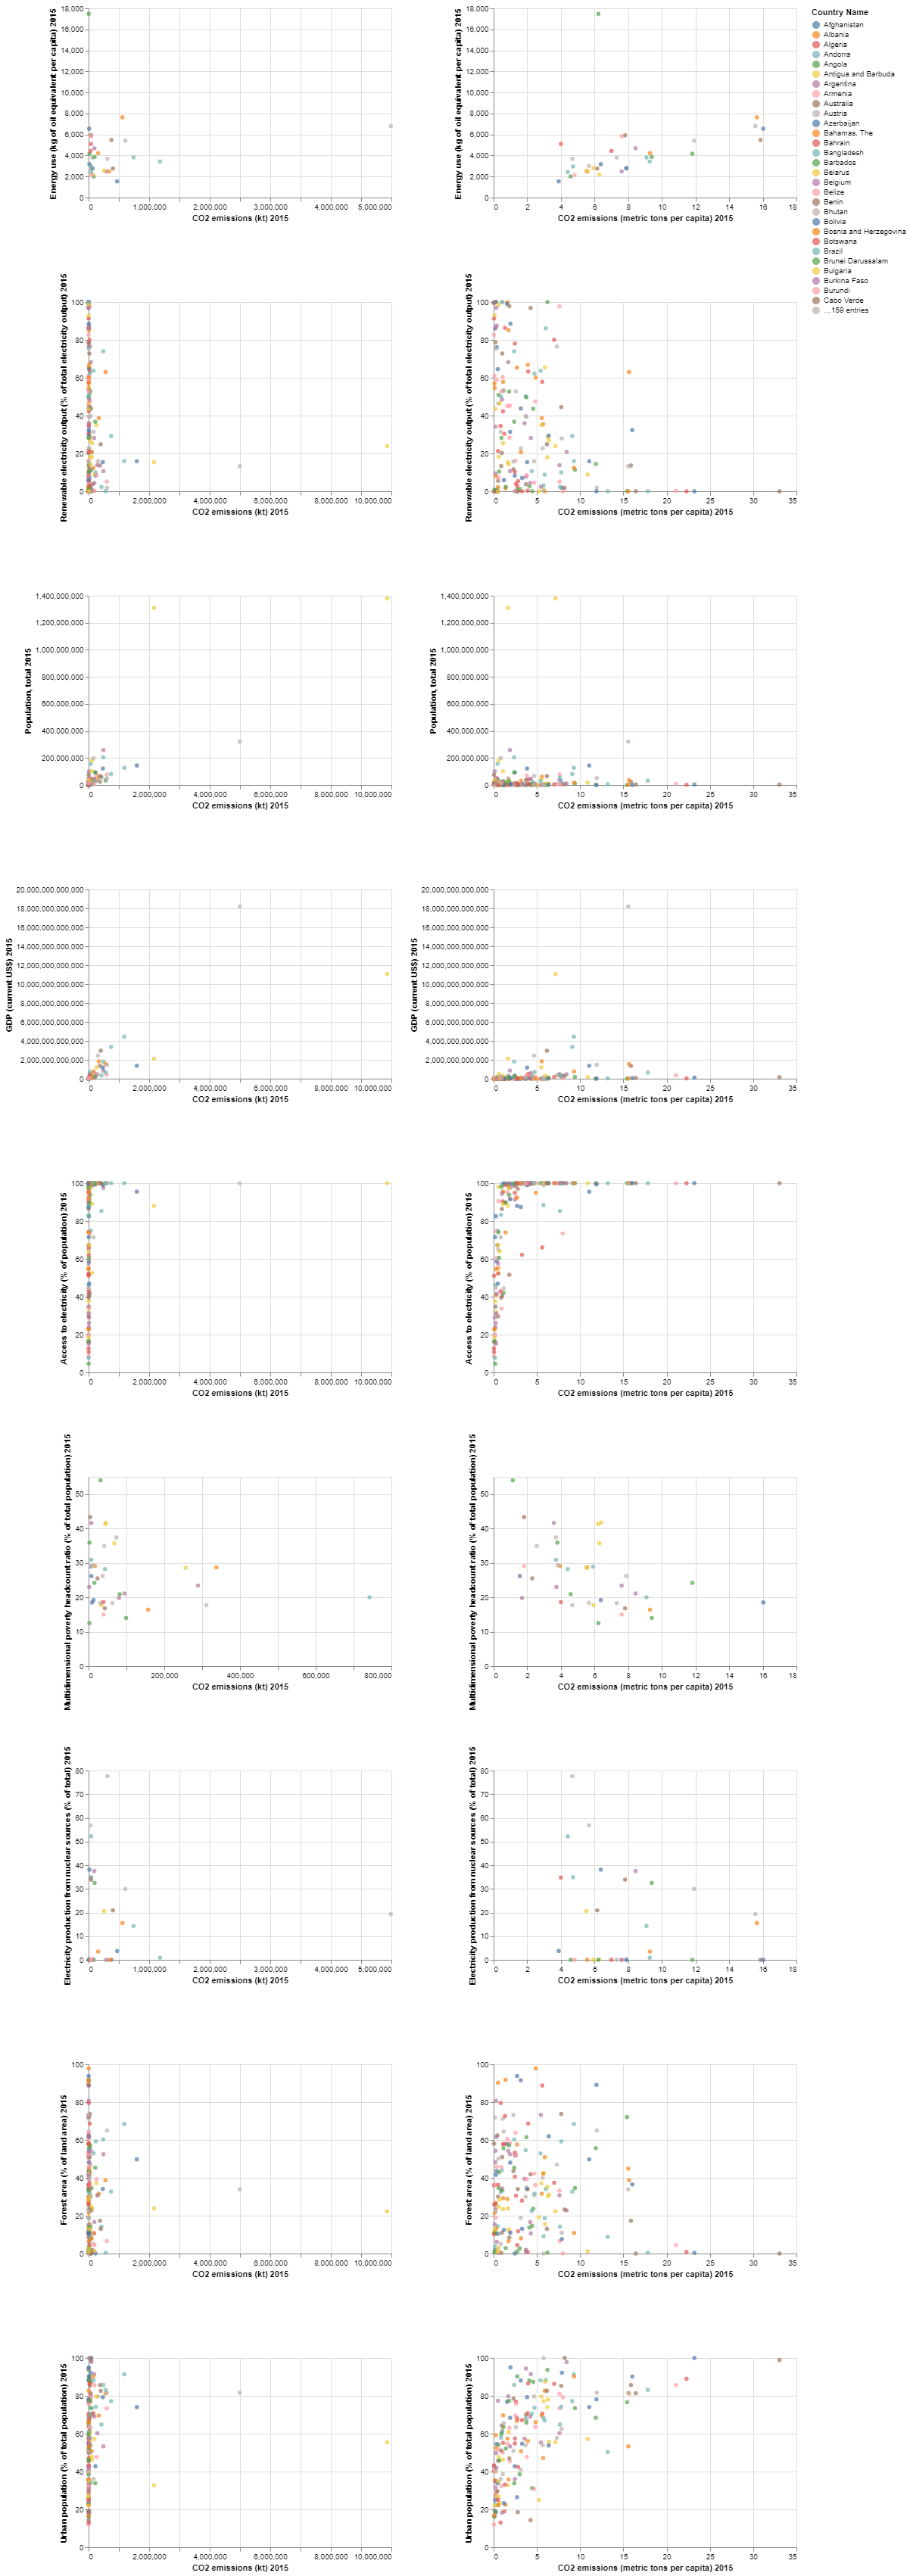

In [21]:


splom_chart= alt.Chart(splom_data).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='Country Name:N',
    tooltip='Country Name'
).properties(
    width=400,
    height=250
).repeat(
    row= ['Energy use (kg of oil equivalent per capita) 2015','Renewable electricity output (% of total electricity output) 2015',
        'Population, total 2015','GDP (current US$) 2015','Access to electricity (% of population) 2015',
        'Multidimensional poverty headcount ratio (% of total population) 2015',
        'Electricity production from nuclear sources (% of total) 2015','Forest area (% of land area) 2015','Urban population (% of total population) 2015'],
    column=['CO2 emissions (kt) 2015', 'CO2 emissions (metric tons per capita) 2015'])

splom_chart

Let's look at some correlation coefficients by category.

In [11]:
#Energy
indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)','Energy use (kg of oil equivalent per capita)',
             'Renewable electricity output (% of total electricity output)','Electricity production from nuclear sources (% of total)', 
             'Electricity production from coal sources (% of total)','Renewable energy consumption (% of total final energy consumption)',
              'Electricity production from natural gas sources (% of total)','Alternative and nuclear energy (% of total energy use)',
              'Fossil fuel energy consumption (% of total)']
new_ind_df = get_ind_df(wdi_df, indi_list, '2015') #some indicators are only in 2015 like renewable energy and Energy use
#print(new_ind_df.head())

#pearson : standard correlation coefficient
corr_df = new_ind_df.corr(method='pearson')
corr_df = corr_df.iloc[:, 0:2]
corr_df

,CO2 emissions (kt) 2015,CO2 emissions (metric tons per capita) 2015
CO2 emissions (kt) 2015,1.000000,0.177665
CO2 emissions (metric tons per capita) 2015,0.177665,1.000000
Energy use (kg of oil equivalent per capita) 2015,0.129602,0.341627
Renewable electricity output (% of total electricity output) 2015,-0.081838,-0.308210
Electricity production from nuclear sources (% of total) 2015,0.009745,-0.231230
Electricity production from coal sources (% of total) 2015,0.273735,0.077639
Renewable energy consumption (% of total final energy consumption) 2015,-0.130136,-0.534918
Electricity production from natural gas sources (% of total) 2015,-0.028782,0.435019
Alternative and nuclear energy (% of total energy use) 2015,-0.120053,-0.356142
Fossil fuel energy consumption (% of total) 2015,0.228820,0.224303


In [12]:
#People and poverty
indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)','Literacy rate, youth female (% of females ages 15-24)',
             'Population, total','Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)','Access to clean fuels and technologies for cooking (% of population)',
              'Access to electricity (% of population)','Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Rural population (% of total population)']

new_ind_df= get_ind_df(wdi_df, indi_list, '2015') 
#print(new_ind_df.head())

#pearson : standard correlation coefficient
corr_df = new_ind_df.corr(method='pearson')
corr_df = corr_df.iloc[:, 0:2]
corr_df

,CO2 emissions (kt) 2015,CO2 emissions (metric tons per capita) 2015
CO2 emissions (kt) 2015,1.000000,0.177665
CO2 emissions (metric tons per capita) 2015,0.177665,1.000000
"Literacy rate, youth female (% of females ages 15-24) 2015",0.307127,0.322519
"Population, total 2015",0.807873,0.012257
Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) 2015,-0.083570,-0.414926
Access to clean fuels and technologies for cooking (% of population) 2015,0.091886,0.576661
Access to electricity (% of population) 2015,0.120528,0.474128
"Adolescent fertility rate (births per 1,000 women ages 15-19) 2015",-0.151579,-0.513735
Rural population (% of total population) 2015,-0.082988,-0.578435


In [13]:
#industry and transportation
indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)', 'Air transport, passengers carried','Railways, goods transported (million ton-km)',
            'Air transport, freight (million ton-km)', 'Rail lines (total route-km)', 'Container port traffic (TEU: 20 foot equivalent units)',
            'Agriculture, forestry, and fishing, value added (% of GDP)']

new_ind_df= get_ind_df(wdi_df, indi_list, '2015') 
#print(new_ind_df.head())

#pearson : standard correlation coefficient
corr_df = new_ind_df.corr(method='pearson')
corr_df = corr_df.iloc[:, 0:2]
corr_df

,CO2 emissions (kt) 2015,CO2 emissions (metric tons per capita) 2015
CO2 emissions (kt) 2015,1.000000,0.177665
CO2 emissions (metric tons per capita) 2015,0.177665,1.000000
"Air transport, passengers carried 2015",0.801659,0.256895
"Railways, goods transported (million ton-km) 2015",0.833483,0.350854
"Air transport, freight (million ton-km) 2015",0.712531,0.398806
Rail lines (total route-km) 2015,0.699387,0.444400
Container port traffic (TEU: 20 foot equivalent units) 2015,0.929195,0.167767
"Agriculture, forestry, and fishing, value added (% of GDP) 2015",-0.092977,-0.533735


In [14]:
#land use and wildlife
indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)','Agricultural land (% of land area)',
              'Forest area (% of land area)','Terrestrial protected areas (% of total land area)',
              'Total natural resources rents (% of GDP)','Fertilizer consumption (kilograms per hectare of arable land)',
              'Bird species, threatened', 'Mammal species, threatened', 'Fish species, threatened']

new_ind_df= get_ind_df(wdi_df, indi_list, '2018') #some indicators are only in 2018 like threatened species
#print(new_ind_df.head())

#pearson : standard correlation coefficient
corr_df = new_ind_df.corr(method='pearson')
corr_df = corr_df.iloc[:, 0:2]
corr_df

,CO2 emissions (kt) 2018,CO2 emissions (metric tons per capita) 2018
CO2 emissions (kt) 2018,1.000000,0.178414
CO2 emissions (metric tons per capita) 2018,0.178414,1.000000
Agricultural land (% of land area) 2018,0.063343,-0.269157
Forest area (% of land area) 2018,-0.027379,-0.081702
Terrestrial protected areas (% of total land area) 2018,-0.027242,0.094676
Total natural resources rents (% of GDP) 2018,-0.037031,0.191733
Fertilizer consumption (kilograms per hectare of arable land) 2018,0.054129,0.369904
"Bird species, threatened 2018",0.367078,-0.053020
"Mammal species, threatened 2018",0.298406,-0.113635
"Fish species, threatened 2018",0.447912,-0.022348


Looks like total CO2 emissions are highly corelated with population and GDP. 

There are not many variables in the list that are highly corelated with CO2 per capita. Some correlated variables include Renewable energy consumption (% of total final energy consumption) 2015, Rural population (% of total population) 2015, and Agriculture, forestry, and fishing, value added (% of GDP) 2015.		

Maybe instead of looking at all countries, I should focus on countries with high GDP per capita and low CO2 emissions per capita. This might illuminate strategies used to lower CO2 emissions while maintaining a high GDP.

In [15]:
indi_list = [ 'CO2 emissions (metric tons per capita)','Population, total','GDP (current US$)']
source = get_ind_df(wdi_df, indi_list, '2015')
source['GDP per capita (current US$) 2015'] = source['GDP (current US$) 2015']/source['Population, total 2015']
source = source.nlargest(30, 'GDP per capita (current US$) 2015')
high_gdp_low_co2 = source[source['CO2 emissions (metric tons per capita) 2015'] < 10]
high_g_low_c = high_gdp_low_co2['Country Name']
#print(source.head())

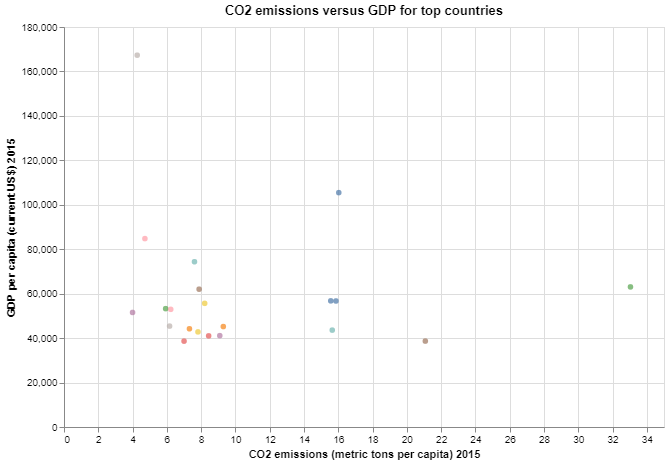

In [22]:
alt.Chart(source).mark_circle().encode(
    x = alt.X('CO2 emissions (metric tons per capita) 2015'),
    y = alt.Y('GDP per capita (current US$) 2015'),
    color = alt.Color('Country Name:N', legend=None),
    tooltip='Country Name'
).properties(width=600, height=400, title='CO2 emissions versus GDP for top countries' ).interactive()


This chart can help me identify countries that have high GDP and relatively low CO2 emissions per capita. In the US transportation, power generation, and industrial activities contribute the most to greenhouse gas emissions.  I could look more closely at data on the in transportation, power generation, and industrial activities sectors in the countries identified above to discover ways to reduce CO2 while maintaining high GDP.

In [18]:
#running the correlation with high GDP and relatively low CO2 emissions per capita countries
country_list = high_g_low_c.to_list()
print(country_list)

indi_list = ['CO2 emissions (kt)', 'CO2 emissions (metric tons per capita)','Urban population (% of total population)',
             'Energy use (kg of oil equivalent per capita)','Renewable electricity output (% of total electricity output)',
             'Population, total','Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)','Access to clean fuels and technologies for cooking (% of population)',
              'Access to electricity (% of population)','Electricity production from nuclear sources (% of total)', 'Air transport, passengers carried',
              'Forest area (% of land area)','Terrestrial protected areas (% of total land area)','Air transport, freight (million ton-km)',
              'Electricity production from coal sources (% of total)','Renewable energy consumption (% of total final energy consumption)',
              'Electricity production from natural gas sources (% of total)','Alternative and nuclear energy (% of total energy use)',
              'Fossil fuel energy consumption (% of total)']


new_ind_df= get_ind_df(wdi_df, indi_list, '2015') #some indicators are only in 2015 like renewable energy and Energy use
#print(new_ind_df.head())
new_ind_df = new_ind_df.loc[new_ind_df['Country Name'].isin(country_list)]

#pearson : standard correlation coefficient
corr_df = new_ind_df.corr(method='pearson')
corr_df = corr_df.iloc[:, 0:2]
corr_df

['Liechtenstein', 'Switzerland', 'Norway', 'Ireland', 'Singapore', 'Denmark', 'Iceland', 'Sweden', 'United Kingdom', 'Netherlands', 'Austria', 'Finland', 'Germany', 'Belgium', 'New Zealand']


,CO2 emissions (kt) 2015,CO2 emissions (metric tons per capita) 2015
CO2 emissions (kt) 2015,1.000000,0.377501
CO2 emissions (metric tons per capita) 2015,0.377501,1.000000
Urban population (% of total population) 2015,0.078646,0.405216
Energy use (kg of oil equivalent per capita) 2015,-0.242852,-0.093299
Renewable electricity output (% of total electricity output) 2015,-0.411504,-0.574758
"Population, total 2015",0.977523,0.272805
Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) 2015,-0.295292,-0.155052
Access to clean fuels and technologies for cooking (% of population) 2015,NaN,NaN
Access to electricity (% of population) 2015,NaN,NaN
Electricity production from nuclear sources (% of total) 2015,0.084528,-0.287043


In this group of countries the highest negative correlation coeficient is between Alternative and nuclear energy (% of total energy use) 2015 and CO2 emissions (metric tons per capita) 2015. Let's take a closer look at this relationship.

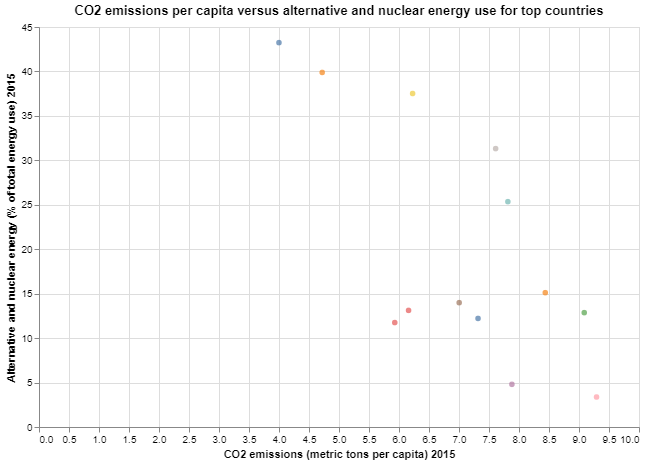

In [24]:
source = new_ind_df
#print(source)

alt.Chart(source).mark_circle().encode(
    x = alt.X('CO2 emissions (metric tons per capita) 2015'),
    y = alt.Y('Alternative and nuclear energy (% of total energy use) 2015'),
    color = alt.Color('Country Name:N', legend=None),
    tooltip='Country Name'
).properties(width=600, height=400, title='CO2 emissions per capita versus alternative and nuclear energy use for top countries' ).interactive()


The chart above might help guide the rest of my analysis. There is a group of countries in the left center (Sweden, Switzerland, Iceland) that have high Alternative and nuclear energy (% of total energy use) values while maintaining low CO2 emissions (metric tons per capita). There is another group of countries bottom center of the chart (Denmark, UK, New Zealand, Austria, Ireland) that have lower Alternative and nuclear energy (% of total energy use) values while also maintaining low CO2 emissions (metric tons per capita). Increasing renewable and nuclear energy production may be one way to lower CO2 emissions but there is clearly other effective ways.

In [ ]:
#Dependencies

%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2023-03-18T07:21:28.296897-04:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 2, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pandas: 1.4.2
numpy : 1.22.3
altair: 4.2.0
json  : 2.0.9

